In [94]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import pandas_ta
import seaborn as sns
import urllib.request
import warnings
import yfinance as yf

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns, risk_models
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm

warnings.filterwarnings('ignore')

### **Plan:** Compare our algo trading bot to the S&P500

In [2]:
warnings.filterwarnings('ignore')
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

#Adding header to mimic a browser visit and avoid 403 error
req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})

sp500 = pd.read_html(urllib.request.urlopen(req))[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

### Extracting the S&P 500 Data for the Past 20 Years

In [3]:
end_date = dt.datetime.now()

start_date = pd.to_datetime(end_date) - pd.DateOffset(365*20)

# Download without stacking
df = yf.download(tickers=symbols_list, 
                 start=start_date,
                 end=end_date)

df.head()

[*********************100%***********************]  503 of 503 completed


Price           Close                                                      \
Ticker              A      AAPL ABBV ABNB        ABT      ACGL        ACN   
Date                                                                        
2006-02-13  20.591724  1.940720  NaN  NaN  13.004356  5.595510  22.765148   
2006-02-14  20.800924  2.028594  NaN  NaN  13.277628  5.801538  22.559992   
2006-02-15  20.914495  2.075979  NaN  NaN  13.405148  5.914588  22.892488   
2006-02-16  20.788975  2.116468  NaN  NaN  13.468912  5.881836  23.224981   
2006-02-17  20.914495  2.108071  NaN  NaN  13.462835  5.913533  23.133015   

Price                                        ...   Volume                    \
Ticker           ADBE        ADI        ADM  ...       WY     WYNN      XEL   
Date                                         ...                              
2006-02-13  38.189999  24.506567  18.810068  ...   864900   702700   637400   
2006-02-14  38.130001  24.799290  18.901825  ...  1685400   954700   922600   
2006-02-15  37.650002  24.182724  18.779089  ...  1308700  1101500   861700   
2006-02-16  38.580002  24.649809  18.760679  ...  1110600  1126800   634000   
2006-02-17  37.799999  24.157820  18.459972  ...  1830700  1128800  1183500   

Price                                                       
Ticker           XOM XYL XYZ      YUM      ZBH    ZBRA ZTS  
Date                                                        
2006-02-13  16837000 NaN NaN  2411438   671766  496000 NaN  
2006-02-14  21022500 NaN NaN  2794797  1030721  518200 NaN  
2006-02-15  21669900 NaN NaN  3554561  1124657  369600 NaN  
2006-02-16  20057500 NaN NaN  2825956   991890  231400 NaN  
2006-02-17  19198900 NaN NaN  2790902  1538511  288100 NaN  

[5 rows x 2515 columns]

In [4]:
data_list = []
for ticker in df.columns.get_level_values(1).unique():
    ticker_df = df.xs(ticker, level=1, axis=1).copy()
    ticker_df['Ticker'] = ticker
    data_list.append(ticker_df)

df = pd.concat(data_list).reset_index()
df = df.rename(columns={'index': 'Date'})
df = df.set_index(['Date', 'Ticker'])

# Reorder columns to match expected format
df = df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] if 'Adj Close' in df.columns else df[['Close', 'High', 'Low', 'Open', 'Volume']]

In [5]:
df.head()

,Price,Close,High,Low,Open,Volume
Date,Ticker,,,,,
2006-02-13,A,20.591724,21.111748,20.334703,21.040021,8885408.0
2006-02-14,A,20.800924,21.057948,20.525969,20.669424,5104098.0
2006-02-15,A,20.914495,20.986222,20.382518,20.651495,4798216.0
2006-02-16,A,20.788975,21.040020,20.741155,20.854725,3285719.0
2006-02-17,A,20.914495,21.004155,20.639541,20.681381,4504915.0


In [6]:
df.index.get_level_values('Ticker').unique()

Index(['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM',
       ...
       'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'XYZ', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', name='Ticker', length=503)

In [7]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df.head()

,Price,close,high,low,open,volume
date,ticker,,,,,
2006-02-13,A,20.591724,21.111748,20.334703,21.040021,8885408.0
2006-02-14,A,20.800924,21.057948,20.525969,20.669424,5104098.0
2006-02-15,A,20.914495,20.986222,20.382518,20.651495,4798216.0
2006-02-16,A,20.788975,21.040020,20.741155,20.854725,3285719.0
2006-02-17,A,20.914495,21.004155,20.639541,20.681381,4504915.0


# Features and Technical Indicators

## Garman-Klass Volatility

It involves calculating the standard deviation of logarithmic price changes over a given period, then applying a smoothing factor to reduce noise and highlight significant volatility shifts.

## RSI Indicator

The RSI ranges from 0 to 100. Traditional interpretation uses levels of 70 and 30 to indicate overbought and oversold conditions

RSI can also show divergence, which occurs when the price of the asset is moving in the opposite direction of the RSI. This can be a signal of a potential reversal. For instance, if the price is making new highs but the RSI is not, it may indicate a weakening trend.

<Axes: xlabel='date'>

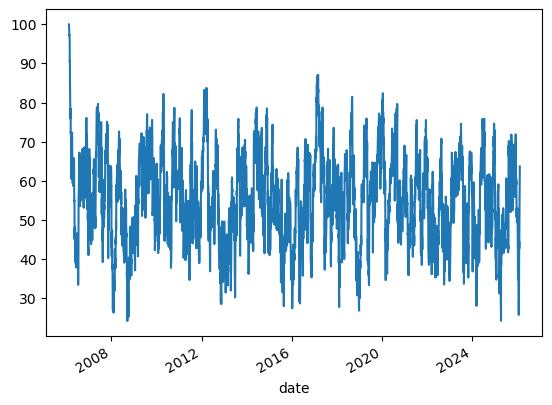

In [8]:
#Gamma-klass volatility
df['german_klass_vol'] = (((np.log(df['high']) - np.log(df['low'])) 
                           ** 2)/2) - ((2 * np.log(2) - 1) * 
                                       ((np. log(df['close'])) - 
                                        np.log(df['open']))**2)

#RSI Indicator
#level 0 is the date, level 1 is the ticker 
df['rsi'] = df.groupby(level=1)['close'].transform(lambda x: 
                            pandas_ta.rsi(close = x, length = 20))

#checking our RSI work
df.xs('AAPL', level=1)['rsi'].plot()

## Bollinger Bands

Bollinger Bands, helps gauge the volatility of stocks and other securities to determine if they are over or undervalued. The center line is the stock price's 20-day simple moving average (SMA). The upper and lower bands are set at a certain number of standard deviations, usually two, above and below the middle line.

The code below, outputs 5 columns. The first column is the lower band, the second column is the middle band, and the final is the upper band.

In [9]:
pandas_ta.bbands(close=df.xs('AAPL', level = 1)['close'], length = 20).tail()

,BBL_20_2.0_2.0,BBM_20_2.0_2.0,BBU_20_2.0_2.0,BBB_20_2.0_2.0,BBP_20_2.0_2.0
date,,,,,
2026-02-02,245.312161,257.599498,269.886835,9.539877,1.005012
2026-02-03,245.022142,257.710498,270.398854,9.846984,0.963792
2026-02-04,243.297878,258.416998,273.536118,11.701336,1.097687
2026-02-05,242.175882,259.195999,276.216117,13.133009,0.991007
2026-02-06,241.143673,260.149998,279.156324,14.611820,0.972737


Similar to RSI, we are going to group by each ticker, select only the adj close column, and use the transform method 'Lambda Function'. We want it to return the log of x and keep length 20 and return only the first column of the table of results above.

In [10]:
df['bb_low'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

df.head()

,Price,close,high,low,open,volume,german_klass_vol,rsi,bb_low,bb_mid,bb_high
date,ticker,,,,,,,,,,
2006-02-13,A,20.591724,21.111748,20.334703,21.040021,8885408.0,0.000524,NaN,NaN,NaN,NaN
2006-02-14,A,20.800924,21.057948,20.525969,20.669424,5104098.0,0.000312,100.000000,NaN,NaN,NaN
2006-02-15,A,20.914495,20.986222,20.382518,20.651495,4798216.0,0.000364,100.000000,NaN,NaN,NaN
2006-02-16,A,20.788975,21.040020,20.741155,20.854725,3285719.0,0.000098,96.869395,NaN,NaN,NaN
2006-02-17,A,20.914495,21.004155,20.639541,20.681381,4504915.0,0.000105,96.969269,NaN,NaN,NaN


Average True Range - ATR
ATR only measures volatility and doesn’t indicate price direction. It takes an average selection of true ranges over a specific period in time. The true range of an asset can be defined by the greatest absolute value of one of the following: |Current High – Current Low| |Current High – Previous Close| |Current Low – Previous Close|

Traders can use ATR as a filter to classify market conditions or to help These true range values are then smoothed over a certain period of time, the most common being 14 periods. With this, traders can use ATR as a filter to classify market conditions or to help define stop losses.

ATR is calculated as: 
$$
\text{Current ATR} = \frac{(\text{Prior ATR} \times (n-1) + \text{Current TR})}{n}
$$

In [11]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                       low = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std()) #Normalizing data by dividing by standard deviation

df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)
#If we don't group_keys=false it will return another date column


df.head()

,Price,close,high,low,open,volume,german_klass_vol,rsi,bb_low,bb_mid,bb_high,atr
date,ticker,,,,,,,,,,,
2006-02-13,A,20.591724,21.111748,20.334703,21.040021,8885408.0,0.000524,NaN,NaN,NaN,NaN,NaN
2006-02-14,A,20.800924,21.057948,20.525969,20.669424,5104098.0,0.000312,100.000000,NaN,NaN,NaN,NaN
2006-02-15,A,20.914495,20.986222,20.382518,20.651495,4798216.0,0.000364,100.000000,NaN,NaN,NaN,NaN
2006-02-16,A,20.788975,21.040020,20.741155,20.854725,3285719.0,0.000098,96.869395,NaN,NaN,NaN,NaN
2006-02-17,A,20.914495,21.004155,20.639541,20.681381,4504915.0,0.000105,96.969269,NaN,NaN,NaN,NaN


## MACD
Moving average convergence divergence (MACD) is one of the most commonly used techincal analysis indicators. It is a trend-following momentum indicator, meaning it looks at an asset’s momentum to ascertain whether the trend is up or down, and as such can be used to provide trading signals and identify trading opportunities.

The MACD indicator works using three components: two moving averages and a histogram.

The two lines within the indicator may look like simple moving averages (SMAs), but they are in fact layered exponential moving averages (EMAs). The main, slower line is the MACD line, while the faster line is the signal line.

In [12]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length = 20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std()) #normalizing the data so that we can input it into a machine learning model

df['macd'] = df.groupby(level=1, group_keys = False)['close'].apply(compute_macd)

df.head()

,Price,close,high,low,open,volume,german_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd
date,ticker,,,,,,,,,,,,
2006-02-13,A,20.591724,21.111748,20.334703,21.040021,8885408.0,0.000524,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-14,A,20.800924,21.057948,20.525969,20.669424,5104098.0,0.000312,100.000000,NaN,NaN,NaN,NaN,NaN
2006-02-15,A,20.914495,20.986222,20.382518,20.651495,4798216.0,0.000364,100.000000,NaN,NaN,NaN,NaN,NaN
2006-02-16,A,20.788975,21.040020,20.741155,20.854725,3285719.0,0.000098,96.869395,NaN,NaN,NaN,NaN,NaN
2006-02-17,A,20.914495,21.004155,20.639541,20.681381,4504915.0,0.000105,96.969269,NaN,NaN,NaN,NaN,NaN


## Dollar Volume

When there is a high level of investor interest in a stock or ETF, and it is traded on a major exchange, it will tend to be highly liquid. High dollar volume liquidity is generally a positive sign, meaning there is significant interest in the stock.

In [13]:
df['dollar_volume'] = (df['close']*df['volume']) / 1e6

df.head()

,Price,close,high,low,open,volume,german_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,ticker,,,,,,,,,,,,,
2006-02-13,A,20.591724,21.111748,20.334703,21.040021,8885408.0,0.000524,NaN,NaN,NaN,NaN,NaN,NaN,182.965873
2006-02-14,A,20.800924,21.057948,20.525969,20.669424,5104098.0,0.000312,100.000000,NaN,NaN,NaN,NaN,NaN,106.169956
2006-02-15,A,20.914495,20.986222,20.382518,20.651495,4798216.0,0.000364,100.000000,NaN,NaN,NaN,NaN,NaN,100.352267
2006-02-16,A,20.788975,21.040020,20.741155,20.854725,3285719.0,0.000098,96.869395,NaN,NaN,NaN,NaN,NaN,68.306729
2006-02-17,A,20.914495,21.004155,20.639541,20.681381,4504915.0,0.000105,96.969269,NaN,NaN,NaN,NaN,NaN,94.218024


## Aggregate to monthly level and filter top 150 most liquid stocks for each month¶

This is to reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

When aggregating to monthly level and filtering top 150 most liquid stocks, we want to use the average for the dollar volume, but all other stocks we want to just take the .last() value, and perform the operations on that.

In [14]:
# Alternative approach without unstack/stack
# Group by date (month-end) and ticker, then aggregate
last_day = df.groupby([pd.Grouper(level='date', freq='ME'), 'ticker']).last()

# For dollar_volume, calculate the mean instead of last
dollar_vol_mean = df.groupby([pd.Grouper(level='date', freq='ME'), 'ticker'])['dollar_volume'].mean()

# Replace dollar_volume in last_day with the mean values
last_day['dollar_volume'] = dollar_vol_mean

last_day.head()

Price                  close       high        low       open        volume  \
date       ticker                                                             
2006-02-28 A       21.518202  21.817065  21.488314  21.667633  3.259018e+06   
           AAPL     2.054085   2.171350   2.042389   2.146758  1.266980e+09   
           ABBV          NaN        NaN        NaN        NaN           NaN   
           ABNB          NaN        NaN        NaN        NaN           NaN   
           ABT     13.414255  13.517489  13.298877  13.380857  1.108920e+07   

Price              german_klass_vol        rsi  bb_low  bb_mid  bb_high  atr  \
date       ticker                                                              
2006-02-28 A               0.000097  88.408599     NaN     NaN      NaN  NaN   
           AAPL            0.001122  90.431795     NaN     NaN      NaN  NaN   
           ABBV                 NaN        NaN     NaN     NaN      NaN  NaN   
           ABNB                 NaN        NaN     NaN     NaN      NaN  NaN   
           ABT             0.000131  92.493949     NaN     NaN      NaN  NaN   

Price              macd  dollar_volume  
date       ticker                       
2006-02-28 A        NaN     101.648867  
           AAPL     NaN    1880.279205  
           ABBV     NaN            NaN  
           ABNB     NaN            NaN  
           ABT      NaN     129.163900

In [15]:
# For indicators we can use the same logic as we used above, but we need to select the specific columns
# Actually we can create a list of columns that we want to do the same operations

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                         'high', 'low']]
last_cols

['close',
 'german_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [16]:
# Instead of df.unstack()[last_cols].resample('M').last().stack('ticker').head()
# Use groupby approach:

monthly_last = df[last_cols].groupby([pd.Grouper(level='date', freq='ME'), 'ticker']).last()

monthly_last.head()

Price                  close  german_klass_vol        rsi  bb_low  bb_mid  \
date       ticker                                                           
2006-02-28 A       21.518202          0.000097  88.408599     NaN     NaN   
           AAPL     2.054085          0.001122  90.431795     NaN     NaN   
           ABBV          NaN               NaN        NaN     NaN     NaN   
           ABNB          NaN               NaN        NaN     NaN     NaN   
           ABT     13.414255          0.000131  92.493949     NaN     NaN   

Price              bb_high  atr  macd  
date       ticker                      
2006-02-28 A           NaN  NaN   NaN  
           AAPL        NaN  NaN   NaN  
           ABBV        NaN  NaN   NaN  
           ABNB        NaN  NaN   NaN  
           ABT         NaN  NaN   NaN

Now we concat the aggregated values of all other features/indicators with the dollar volumes

In [17]:
# Combine dollar_volume (with mean aggregation) and other columns (with last aggregation)
data = pd.concat([
    df.groupby([pd.Grouper(level='date', freq='ME'), 'ticker'])['dollar_volume'].mean().to_frame('dollar_volume'),
    df[last_cols].groupby([pd.Grouper(level='date', freq='ME'), 'ticker']).last()
], axis=1).dropna()

data.head()

dollar_volume      close  german_klass_vol        rsi  \
date       ticker                                                          
2006-03-31 A           80.539872  22.444674          0.000026  68.953500   
           AAPL      1916.212193   1.881038          0.000210  65.320967   
           ABT        132.125556  12.895048          0.000106  62.484201   
           ACGL         9.380520   6.100543          0.000161  82.381965   
           ACN         74.480518  21.272470          0.000132  31.107139   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2006-03-31 A       3.111848  3.140309  3.168771 -0.932401  0.078074  
           AAPL    1.012632  1.064054  1.115475 -0.780876 -0.242157  
           ABT     2.625584  2.661944  2.698304 -0.918626 -0.247401  
           ACGL    1.914836  1.937288  1.959739 -0.879439 -0.154040  
           ACN     3.092633  3.143750  3.194867 -0.843028 -0.248676

## 5-Yr Rolling Average Dollar Vol.
Now we need to calculate the 5-Year rolling average dollar volume for each stock. After, we then use this aggregated dollar volume to filter out the top 50 liquid stocks for each month.

In [18]:
# Using transform for cleaner syntax
data['dollar_volume'] = data.groupby(level='ticker')['dollar_volume'].transform(
    lambda x: x.rolling(window=5*12, min_periods=12).mean()
)

data.head()

dollar_volume      close  german_klass_vol        rsi  \
date       ticker                                                          
2006-03-31 A                 NaN  22.444674          0.000026  68.953500   
           AAPL              NaN   1.881038          0.000210  65.320967   
           ABT               NaN  12.895048          0.000106  62.484201   
           ACGL              NaN   6.100543          0.000161  82.381965   
           ACN               NaN  21.272470          0.000132  31.107139   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2006-03-31 A       3.111848  3.140309  3.168771 -0.932401  0.078074  
           AAPL    1.012632  1.064054  1.115475 -0.780876 -0.242157  
           ABT     2.625584  2.661944  2.698304 -0.918626 -0.247401  
           ACGL    1.914836  1.937288  1.959739 -0.879439 -0.154040  
           ACN     3.092633  3.143750  3.194867 -0.843028 -0.248676

Tickers with the lowest dollar volume have the highest rank.

In [19]:
# Calculating the dollar volume rank, cross-sectionally for each month
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending = False)
data.tail()

dollar_volume       close  german_klass_vol        rsi  \
date       ticker                                                           
2026-02-28 XYZ       1049.839391   55.970001          0.000313  36.704721   
           YUM        231.504697  162.929993          0.000041  65.554450   
           ZBH        181.013319   89.910004          0.000125  51.352651   
           ZBRA       140.169702  251.399994          0.000297  51.155857   
           ZTS        396.007057  127.419998          0.000346  54.822085   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2026-02-28 XYZ     4.014269  4.159072  4.303874 -0.400759 -0.696838   
           YUM     5.021043  5.059736  5.098429  2.404493  1.718112   
           ZBH     4.444312  4.486550  4.528789  0.335888 -0.450370   
           ZBRA    5.431100  5.510876  5.590653  0.962822 -0.575089   
           ZTS     4.808382  4.833030  4.857678  0.452894  0.083411   

                   dollar_vol_rank  
date       ticker                   
2026-02-28 XYZ                44.0  
           YUM               282.0  
           ZBH               342.0  
           ZBRA              397.0  
           ZTS               159.0

In [20]:
#selecting the stocks that are below 150 for each month
data = data[data['dollar_vol_rank']<151].drop(['dollar_volume', 'dollar_vol_rank'], axis = 1) 
#we can now assign this filter and drop dollar volume and dollar volume rank columns
data.head()

close  german_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2007-02-28 A       20.141661          0.000152  41.916363  3.041524  3.075257   
           AAPL     2.537543          0.000333  46.340415  1.241469  1.272749   
           ABT     17.018824          0.000419  69.801440  2.837568  2.862228   
           ADBE    39.250000          0.000378  48.681636  3.640310  3.693603   
           ADI     23.035685          0.000085  66.202476  3.031308  3.114929   

                    bb_high       atr      macd  
date       ticker                                
2007-02-28 A       3.108989 -0.880921 -0.160612  
           AAPL    1.304029 -0.780430 -0.206953  
           ABT     2.886889 -0.885288  0.082479  
           ADBE    3.746896 -0.763063 -0.030399  
           ADI     3.198549 -0.799937  0.078200

## Calculate Monthly Returns for different time horizons as features
To capture time series dynamics that reflect (for ex. momentum patterns, we compute historical returns using the method .pct_change(lag) that is, returns over various monthly periods as identified by lags

In [21]:
# Quick example with Apple stock
g = df.xs('AAPL', level = 1)
g.head()

Price,close,high,low,open,volume,german_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,,,,,,,,,,,,,
2006-02-13,1.940720,2.001903,1.938621,1.998303,8.834980e+08,0.000186,NaN,NaN,NaN,NaN,NaN,NaN,1714.622310
2006-02-14,2.028594,2.042390,1.949418,1.952417,1.160939e+09,0.000519,100.000000,NaN,NaN,NaN,NaN,NaN,2355.073227
2006-02-15,2.075979,2.087976,2.001902,2.014198,1.159771e+09,0.000534,100.000000,NaN,NaN,NaN,NaN,NaN,2407.661202
2006-02-16,2.116468,2.129664,2.083779,2.096675,9.481752e+08,0.000203,100.000000,NaN,NaN,NaN,NaN,NaN,2006.782650
2006-02-17,2.108071,2.126066,2.087677,2.108371,5.759992e+08,0.000166,99.473981,NaN,NaN,NaN,NaN,NaN,1214.246986


In [22]:
def calculate_returns(df):
# The number of monthly lags that we want to calculate for (e.g. 3 month lag, 6 month lag, etc.)
    lags = [1, 2, 3, 6, 9, 12] 

    outlier_cutoff = 0.005

    for lag in lags:
        df[f'return_{lag}m'] = (df['close']
                          .pct_change(lag)
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), #dealing with outliers
                                                 upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                          )
    return df

data = data.groupby(level=1, group_keys = False).apply(calculate_returns).dropna()
# Level 1 group by is to group by ticker levels
# Group keys are assigned to be false, so we don't have to date indexes assigned to the new dataframe
# Then we apply the calculate_returns function we created above
data.head()

close  german_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2008-02-29 AAPL     3.749480          0.000465  39.534473  1.504577  1.558528   
           ABT     17.078829          0.000094  38.357406  2.891664  2.936177   
           ADBE    33.650002          0.000365  37.752168  3.517801  3.570264   
           ADM     28.335373          0.000405  55.559323  3.282919  3.355395   
           ADSK    31.090000          0.001029  24.087748  3.519844  3.663764   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2008-02-29 AAPL    1.612480 -0.713473 -0.323589  -0.076389  -0.196823   
           ABT     2.980689 -0.714485 -0.447490  -0.046814  -0.020776   
           ADBE    3.622727 -0.749051 -0.133295  -0.036645  -0.112586   
           ADM     3.427872  0.286532  0.570412   0.028508  -0.012966   
           ADSK    3.807684 -0.583223 -0.781554  -0.244471  -0.209558   

                   return_3m  return_6m  return_9m  return_12m  
date       ticker                                               
2008-02-29 AAPL    -0.118015  -0.016898   0.003463    0.033070  
           ABT     -0.021734   0.007114  -0.003702    0.000293  
           ADBE    -0.072252  -0.039107  -0.029505   -0.012746  
           ADM      0.075605   0.050835   0.029523    0.024032  
           ADSK    -0.129242  -0.064288  -0.041314   -0.023091

## Aggregate to monthly level and filter top 150 most liquid stocks for each month

This is to reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

When aggregating to monthly level and filtering top 150 most liquid stocks, we want to use the average for the dollar volume, but all other stocks we want to just take the .last() value, and perform the operations on that.

In [23]:
# We can use the pandas datar eaders package
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
              'famafrench',
              start = '2010')[0].drop('RF', axis = 1)
# This will return a dictionary with two keys, both monthly factors and yearly factors. 
# Since we only want monthly factors we specify for key [0]
# Risk-free factor is going to be out of the scope of this as well.

In [24]:
factor_data.index = factor_data.index.to_timestamp()

In [25]:
factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-01,-3.35,0.40,0.33,-1.08,0.51
2010-02-01,3.39,1.49,3.18,-0.29,1.42
2010-03-01,6.30,1.83,2.19,-0.61,1.74
2010-04-01,2.00,4.96,2.96,0.61,1.75
2010-05-01,-7.90,0.08,-2.48,1.30,-0.24


In [26]:
# The issue after running the data is that the date is beginning of the month, but we above we are using EOM
# Other issue is that the factors are also in percentages, so we need to divide by 100
factor_data = factor_data.resample('ME').last().div(100)

In [27]:
# fix also the date name to be in line with the lowercap as we used in previous tables
factor_data.index.name = 'date'
factor_data.head()

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0335,0.0040,0.0033,-0.0108,0.0051
2010-02-28,0.0339,0.0149,0.0318,-0.0029,0.0142
2010-03-31,0.0630,0.0183,0.0219,-0.0061,0.0174
2010-04-30,0.0200,0.0496,0.0296,0.0061,0.0175
2010-05-31,-0.0790,0.0008,-0.0248,0.0130,-0.0024


Now we can join with the 1 month return... This is because we have the factors from the beginning of each month, and we have the return of each stock at the end of the same month. Now, we have fixed the date of the factors. We can just join with the EOM return. Then, we can regress them and take the Beta.

If the factor is predictive, we have it at the beginning of the month, and we will regress it with the return of the EOM. So we'll get the beta.

In [28]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.head()

Mkt-RF    SMB     HML     RMW     CMA  return_1m
date       ticker                                                  
2010-01-31 AAPL   -0.0335  0.004  0.0033 -0.0108  0.0051  -0.088597
           ABT    -0.0335  0.004  0.0033 -0.0108  0.0051  -0.012287
           ADBE   -0.0335  0.004  0.0033 -0.0108  0.0051  -0.121805
           ADM    -0.0335  0.004  0.0033 -0.0108  0.0051  -0.042798
           ADSK   -0.0335  0.004  0.0033 -0.0108  0.0051  -0.063754

In [29]:
# Now to check our work... we compare AAPL vs MSFT
# We want to see that CMA is same, but return_1m is different
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2010-01-31,-0.0335,0.0040,0.0033,-0.0108,0.0051,-0.088597
2010-02-28,0.0339,0.0149,0.0318,-0.0029,0.0142,0.065396
2010-03-31,0.0630,0.0183,0.0219,-0.0061,0.0174,0.148470
2010-04-30,0.0200,0.0496,0.0296,0.0061,0.0175,0.111021
2010-05-31,-0.0790,0.0008,-0.0248,0.0130,-0.0024,-0.016125


In [30]:
factor_data.xs('MSFT', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2010-01-31,-0.0335,0.0040,0.0033,-0.0108,0.0051,-0.075459
2010-02-28,0.0339,0.0149,0.0318,-0.0029,0.0142,0.022145
2010-03-31,0.0630,0.0183,0.0219,-0.0061,0.0174,0.021626
2010-04-30,0.0200,0.0496,0.0296,0.0061,0.0175,0.042676
2010-05-31,-0.0790,0.0008,-0.0248,0.0130,-0.0024,-0.151394


Now we are going to filter out stocks with less than 10 months data
- We are doing this because we are going to use rolling window for the regression of around 2 years (24 months)
- Stocks that don't have enough data will actually break our function.

In [31]:
#This shows us the months of data we have for each ticker
factor_data.groupby(level=1).size()

ticker
A        12
AAPL    192
ABBV    133
ABNB     37
ABT     192
       ... 
XOM     192
XYZ      84
YUM      83
ZBH      24
ZTS      12
Length: 234, dtype: int64

In [32]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
valid_stocks

ticker
A        12
AAPL    192
ABBV    133
ABNB     37
ABT     192
       ... 
XOM     192
XYZ      84
YUM      83
ZBH      24
ZTS      12
Length: 224, dtype: int64

In [33]:
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data.head()

Mkt-RF    SMB     HML     RMW     CMA  return_1m
date       ticker                                                  
2010-01-31 AAPL   -0.0335  0.004  0.0033 -0.0108  0.0051  -0.088597
           ABT    -0.0335  0.004  0.0033 -0.0108  0.0051  -0.012287
           ADBE   -0.0335  0.004  0.0033 -0.0108  0.0051  -0.121805
           ADM    -0.0335  0.004  0.0033 -0.0108  0.0051  -0.042798
           ADSK   -0.0335  0.004  0.0033 -0.0108  0.0051  -0.063754

## Calculating our Rolling Factor Betas
We want to create a rollingregression on the factor data
https://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingOLS.html

In [34]:
betas = (factor_data.groupby(level=1,
                   group_keys=False)
 .apply(lambda x: RollingOLS(endog = x['return_1m'],
                            exog = sm.add_constant(x.drop('return_1m',
                                         axis = 1)),
                            window = min(24, x.shape[0]), #for 24 months,
                            min_nobs = len(x.columns) + 1) #at least number of columns plus 1
                             .fit(params_only = True)
                             .params
                             .drop('const', axis = 1)))
betas.tail()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2025-12-31 WDAY    0.535029 -0.563859 -0.125885 -1.130839  0.551250
           WFC     1.041919 -0.196265  0.667809 -1.384221  0.112611
           WMT     1.129940 -0.298074  0.359009  0.463754 -0.967380
           XOM     0.519607 -0.425260  1.229088 -0.016915  0.118671
           XYZ     1.127554  1.370030 -1.575628 -2.169121  0.624058

### Joining the Rolling Factor Betas
Next step is to join these RFBs into our current features. But to do that, we need to think a little bit...

We have the Rolling factor that we used at the beginning of the month
The returns are at the end of the month
These Betas, we will only know in the next month. So we cannot blindly join them...

In [35]:
# Shifting the data on the ticker level (not the whole data frame)
betas.groupby('ticker').shift().head()

Mkt-RF  SMB  HML  RMW  CMA
date       ticker                            
2010-01-31 AAPL       NaN  NaN  NaN  NaN  NaN
           ABT        NaN  NaN  NaN  NaN  NaN
           ADBE       NaN  NaN  NaN  NaN  NaN
           ADM        NaN  NaN  NaN  NaN  NaN
           ADSK       NaN  NaN  NaN  NaN  NaN

In [36]:
# Now we can join based on this corrected shifted beta values
data = data.join(betas.groupby('ticker').shift())
data.head()

close  german_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2008-02-29 AAPL     3.749480          0.000465  39.534473  1.504577  1.558528   
           ABT     17.078829          0.000094  38.357406  2.891664  2.936177   
           ADBE    33.650002          0.000365  37.752168  3.517801  3.570264   
           ADM     28.335373          0.000405  55.559323  3.282919  3.355395   
           ADSK    31.090000          0.001029  24.087748  3.519844  3.663764   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2008-02-29 AAPL    1.612480 -0.713473 -0.323589  -0.076389  -0.196823   
           ABT     2.980689 -0.714485 -0.447490  -0.046814  -0.020776   
           ADBE    3.622727 -0.749051 -0.133295  -0.036645  -0.112586   
           ADM     3.427872  0.286532  0.570412   0.028508  -0.012966   
           ADSK    3.807684 -0.583223 -0.781554  -0.244471  -0.209558   

                   return_3m  return_6m  return_9m  return_12m  Mkt-RF  SMB  \
date       ticker                                                             
2008-02-29 AAPL    -0.118015  -0.016898   0.003463    0.033070     NaN  NaN   
           ABT     -0.021734   0.007114  -0.003702    0.000293     NaN  NaN   
           ADBE    -0.072252  -0.039107  -0.029505   -0.012746     NaN  NaN   
           ADM      0.075605   0.050835   0.029523    0.024032     NaN  NaN   
           ADSK    -0.129242  -0.064288  -0.041314   -0.023091     NaN  NaN   

                   HML  RMW  CMA  
date       ticker                 
2008-02-29 AAPL    NaN  NaN  NaN  
           ABT     NaN  NaN  NaN  
           ADBE    NaN  NaN  NaN  
           ADM     NaN  NaN  NaN  
           ADSK    NaN  NaN  NaN

In [37]:
# No more N/As anymore, as they have been imputed by the average for this factor
factors = ['Mkt-RF','SMB','HML','RMW','CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))
data.head()

close  german_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2008-02-29 AAPL     3.749480          0.000465  39.534473  1.504577  1.558528   
           ABT     17.078829          0.000094  38.357406  2.891664  2.936177   
           ADBE    33.650002          0.000365  37.752168  3.517801  3.570264   
           ADM     28.335373          0.000405  55.559323  3.282919  3.355395   
           ADSK    31.090000          0.001029  24.087748  3.519844  3.663764   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2008-02-29 AAPL    1.612480 -0.713473 -0.323589  -0.076389  -0.196823   
           ABT     2.980689 -0.714485 -0.447490  -0.046814  -0.020776   
           ADBE    3.622727 -0.749051 -0.133295  -0.036645  -0.112586   
           ADM     3.427872  0.286532  0.570412   0.028508  -0.012966   
           ADSK    3.807684 -0.583223 -0.781554  -0.244471  -0.209558   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2008-02-29 AAPL    -0.118015  -0.016898   0.003463    0.033070  1.131541   
           ABT     -0.021734   0.007114  -0.003702    0.000293  1.069825   
           ADBE    -0.072252  -0.039107  -0.029505   -0.012746  1.101859   
           ADM      0.075605   0.050835   0.029523    0.024032  0.924213   
           ADSK    -0.129242  -0.064288  -0.041314   -0.023091  0.772331   

                        SMB       HML       RMW       CMA  
date       ticker                                          
2008-02-29 AAPL   -0.175086 -0.213477  1.098505 -1.096319  
           ABT    -0.281052 -0.393477  0.142984  0.657983  
           ADBE   -0.234335 -0.147446 -0.465201 -0.745303  
           ADM    -0.536440 -0.360772 -1.146876  0.087331  
           ADSK    0.469639 -1.024914 -2.335016  0.838399

In [38]:
# Just to make sure, we can now .dropna() just to drop any there are
data = data.drop('close', axis = 1)
data = data.dropna()
data.head()

german_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2008-02-29 AAPL            0.000465  39.534473  1.504577  1.558528  1.612480   
           ABT             0.000094  38.357406  2.891664  2.936177  2.980689   
           ADBE            0.000365  37.752168  3.517801  3.570264  3.622727   
           ADM             0.000405  55.559323  3.282919  3.355395  3.427872   
           ADSK            0.001029  24.087748  3.519844  3.663764  3.807684   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2008-02-29 AAPL   -0.713473 -0.323589  -0.076389  -0.196823  -0.118015   
           ABT    -0.714485 -0.447490  -0.046814  -0.020776  -0.021734   
           ADBE   -0.749051 -0.133295  -0.036645  -0.112586  -0.072252   
           ADM     0.286532  0.570412   0.028508  -0.012966   0.075605   
           ADSK   -0.583223 -0.781554  -0.244471  -0.209558  -0.129242   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2008-02-29 AAPL    -0.016898   0.003463    0.033070  1.131541 -0.175086   
           ABT      0.007114  -0.003702    0.000293  1.069825 -0.281052   
           ADBE    -0.039107  -0.029505   -0.012746  1.101859 -0.234335   
           ADM      0.050835   0.029523    0.024032  0.924213 -0.536440   
           ADSK    -0.064288  -0.041314   -0.023091  0.772331  0.469639   

                        HML       RMW       CMA  
date       ticker                                
2008-02-29 AAPL   -0.213477  1.098505 -1.096319  
           ABT    -0.393477  0.142984  0.657983  
           ADBE   -0.147446 -0.465201 -0.745303  
           ADM    -0.360772 -1.146876  0.087331  
           ADSK   -1.024914 -2.335016  0.838399

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30832 entries, (Timestamp('2008-02-29 00:00:00'), 'AAPL') to (Timestamp('2026-02-28 00:00:00'), 'XYZ')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   german_klass_vol  30832 non-null  float64
 1   rsi               30832 non-null  float64
 2   bb_low            30832 non-null  float64
 3   bb_mid            30832 non-null  float64
 4   bb_high           30832 non-null  float64
 5   atr               30832 non-null  float64
 6   macd              30832 non-null  float64
 7   return_1m         30832 non-null  float64
 8   return_2m         30832 non-null  float64
 9   return_3m         30832 non-null  float64
 10  return_6m         30832 non-null  float64
 11  return_9m         30832 non-null  float64
 12  return_12m        30832 non-null  float64
 13  Mkt-RF            30832 non-null  float64
 14  SMB               30832 non-null  float64
 15  HML       

## Now We Have Finished the Data Wrangling Portion

We can now apply the machine learning models from here on out...
- What we need to decide from here on, is to form a portfolio with some of the stocks from our dataset
- Each month we have the top 150 most liquid stocks and now at the end of each month, we have to decide the stocks we want to have in our portfolio for each month
- We will utilize a machine learning model to determine which stocks to include in the portfolio
- In this tutorial we are only focusing on long-portfolios
- We can also use the machine learning model to determine the magnitude (or 'weight') of each stock in the portfolio
- We can also build an unsupervised learning model using K-Means Clustering (an unsupervised model) to decide which stocks to use in the portfolio based on grouping - to keep things simple

### For each month fit a K-Means Clustering Algorithm to group similar assets based on their features
### K-Means Clustering
- We might want to initialize predefined centroids for each cluster based on our research.
- For this assignment we are going to fit the K-Means Clustering algorithm for each month and split the stocks into four different groups based on their features
- We are using 4 features, because that is what was best for this specific context

In [40]:
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4,
                          random_state = 0,
                          init = 'random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

data.head()

german_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2008-02-29 AAPL            0.000465  39.534473  1.504577  1.558528  1.612480   
           ABT             0.000094  38.357406  2.891664  2.936177  2.980689   
           ADBE            0.000365  37.752168  3.517801  3.570264  3.622727   
           ADM             0.000405  55.559323  3.282919  3.355395  3.427872   
           ADSK            0.001029  24.087748  3.519844  3.663764  3.807684   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2008-02-29 AAPL   -0.713473 -0.323589  -0.076389  -0.196823  -0.118015   
           ABT    -0.714485 -0.447490  -0.046814  -0.020776  -0.021734   
           ADBE   -0.749051 -0.133295  -0.036645  -0.112586  -0.072252   
           ADM     0.286532  0.570412   0.028508  -0.012966   0.075605   
           ADSK   -0.583223 -0.781554  -0.244471  -0.209558  -0.129242   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2008-02-29 AAPL    -0.016898   0.003463    0.033070  1.131541 -0.175086   
           ABT      0.007114  -0.003702    0.000293  1.069825 -0.281052   
           ADBE    -0.039107  -0.029505   -0.012746  1.101859 -0.234335   
           ADM      0.050835   0.029523    0.024032  0.924213 -0.536440   
           ADSK    -0.064288  -0.041314   -0.023091  0.772331  0.469639   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2008-02-29 AAPL   -0.213477  1.098505 -1.096319        0  
           ABT    -0.393477  0.142984  0.657983        0  
           ADBE   -0.147446 -0.465201 -0.745303        0  
           ADM    -0.360772 -1.146876  0.087331        1  
           ADSK   -1.024914 -2.335016  0.838399        3

In [41]:
#Visualizing the Clusters
def plot_clusters(data):
    
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    
    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], 
                color = 'red', label = 'cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], 
                color = 'green', label = 'cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], 
                color = 'blue', label = 'cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], 
                color = 'black', label = 'cluster 3')
    
    plt.legend()
    plt.show()
    return


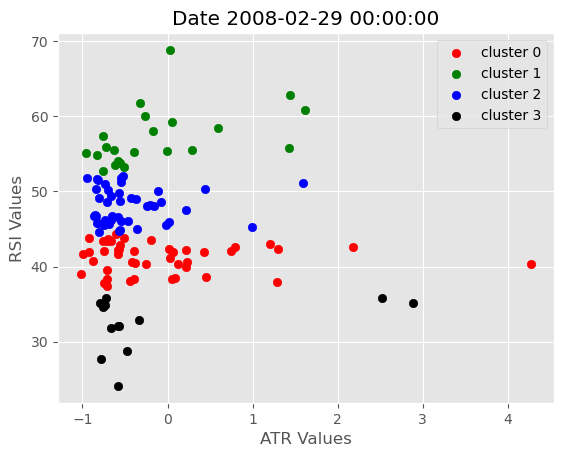

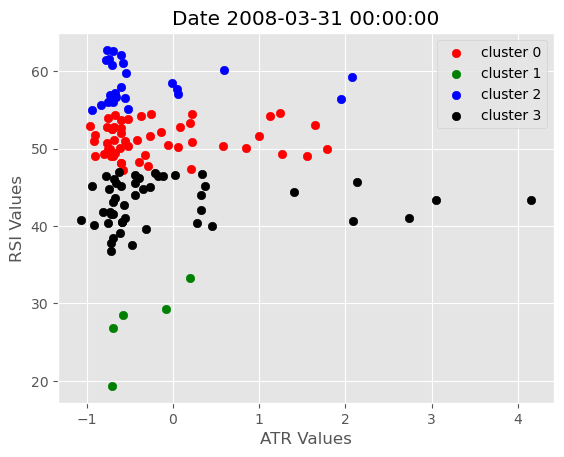

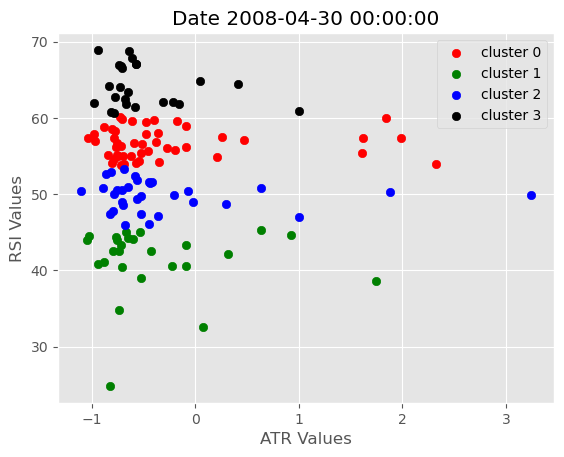

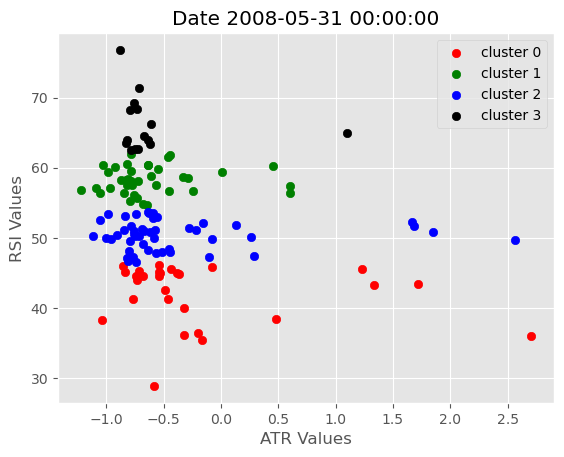

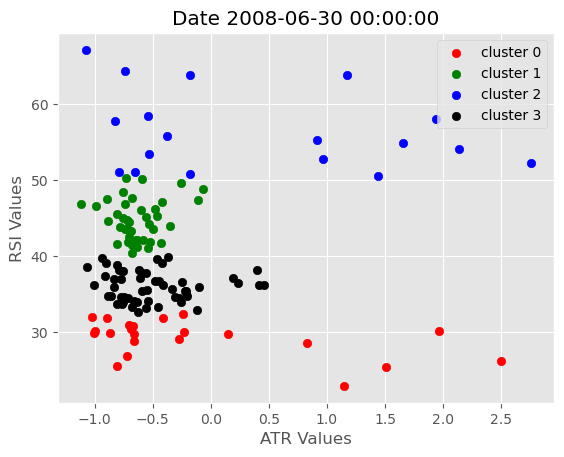

In [42]:
plt.style.use('ggplot')

plot_limit = 5
counter = 0

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plt.xlabel("ATR Values")  # Set x-axis title
    plt.ylabel("RSI Values")  # Set y-axis title
    plot_clusters(g)
    
    counter += 1
    
    if counter == plot_limit:
        break


### Clustering is in brackets of RSI values over each month
- But the issue is that over each month, the cluster zero is sometime between 50 and 60 RSI Values and other months it moves to a different bandwidth
- The strategy that we want to apply is we want to follow the stocks momentum
- Stocks near the 70 RSI are in the upward momentum
- Our strategy will be to invest in the stocks that have the highest upward momentum every month
- So we look at stocks that are in the cluster between 65 to 70/75 RSI
- However, the random initialization of the clusters would not work
- We can help the initial K-Means Clustering by supplying the centeroids

#### Supplying the centeroids to adjust the K-Means Clustering Algorithm
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Based on the K-Means documentation, we need to supply to the clustering algorithm

In [43]:
target_rsi_values = [40, 55, 65, 80]

initial_centroids = np.zeros((len(target_rsi_values),18))

#Incorporate the target RSI Values into the initial centroids
initial_centroids[:, 6] = target_rsi_values 

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 65.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 80.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

#### Reprogram the Initial K-Means Clustering¶
We will reprogram the initial clustering with the new target RSI values

In [44]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis = 1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters = 4,
                          random_state = 0,
                          init = initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys = False).apply(get_clusters)

data.head()

german_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2008-02-29 AAPL            0.000465  39.534473  1.504577  1.558528  1.612480   
           ABT             0.000094  38.357406  2.891664  2.936177  2.980689   
           ADBE            0.000365  37.752168  3.517801  3.570264  3.622727   
           ADM             0.000405  55.559323  3.282919  3.355395  3.427872   
           ADSK            0.001029  24.087748  3.519844  3.663764  3.807684   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2008-02-29 AAPL   -0.713473 -0.323589  -0.076389  -0.196823  -0.118015   
           ABT    -0.714485 -0.447490  -0.046814  -0.020776  -0.021734   
           ADBE   -0.749051 -0.133295  -0.036645  -0.112586  -0.072252   
           ADM     0.286532  0.570412   0.028508  -0.012966   0.075605   
           ADSK   -0.583223 -0.781554  -0.244471  -0.209558  -0.129242   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2008-02-29 AAPL    -0.016898   0.003463    0.033070  1.131541 -0.175086   
           ABT      0.007114  -0.003702    0.000293  1.069825 -0.281052   
           ADBE    -0.039107  -0.029505   -0.012746  1.101859 -0.234335   
           ADM      0.050835   0.029523    0.024032  0.924213 -0.536440   
           ADSK    -0.064288  -0.041314   -0.023091  0.772331  0.469639   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2008-02-29 AAPL   -0.213477  1.098505 -1.096319        3  
           ABT    -0.393477  0.142984  0.657983        0  
           ADBE   -0.147446 -0.465201 -0.745303        0  
           ADM    -0.360772 -1.146876  0.087331        2  
           ADSK   -1.024914 -2.335016  0.838399        0

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30832 entries, (Timestamp('2008-02-29 00:00:00'), 'AAPL') to (Timestamp('2026-02-28 00:00:00'), 'XYZ')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   german_klass_vol  30832 non-null  float64
 1   rsi               30832 non-null  float64
 2   bb_low            30832 non-null  float64
 3   bb_mid            30832 non-null  float64
 4   bb_high           30832 non-null  float64
 5   atr               30832 non-null  float64
 6   macd              30832 non-null  float64
 7   return_1m         30832 non-null  float64
 8   return_2m         30832 non-null  float64
 9   return_3m         30832 non-null  float64
 10  return_6m         30832 non-null  float64
 11  return_9m         30832 non-null  float64
 12  return_12m        30832 non-null  float64
 13  Mkt-RF            30832 non-null  float64
 14  SMB               30832 non-null  float64
 15  HML       

In [46]:
#Visualizing the Clusters
def plot_clusters(data):
    
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    
    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], 
                color = 'red', label = 'cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], 
                color = 'green', label = 'cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], 
                color = 'blue', label = 'cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], 
                color = 'black', label = 'cluster 3')
    
    plt.legend()
    plt.show()
    return

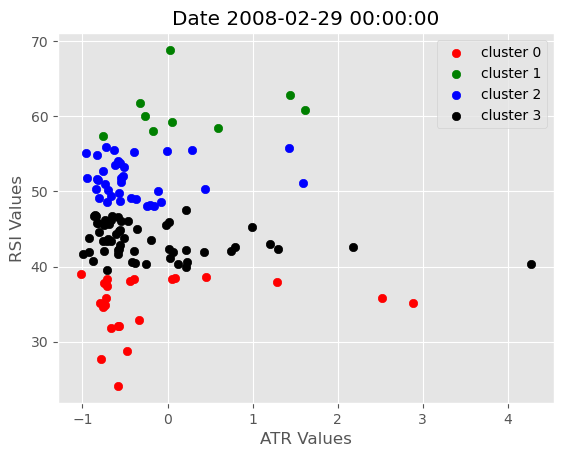

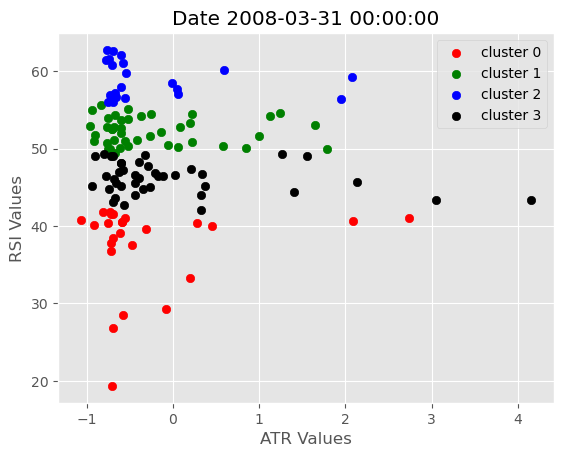

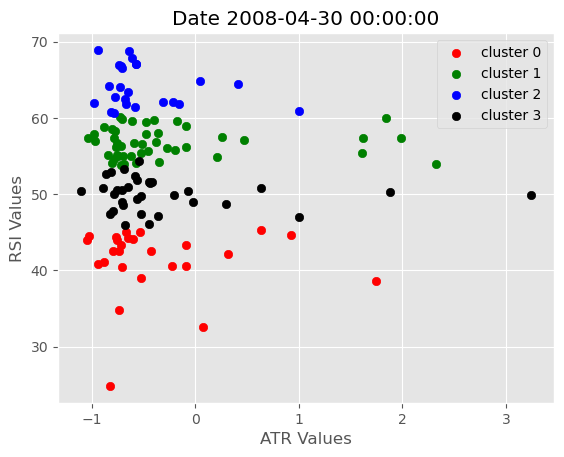

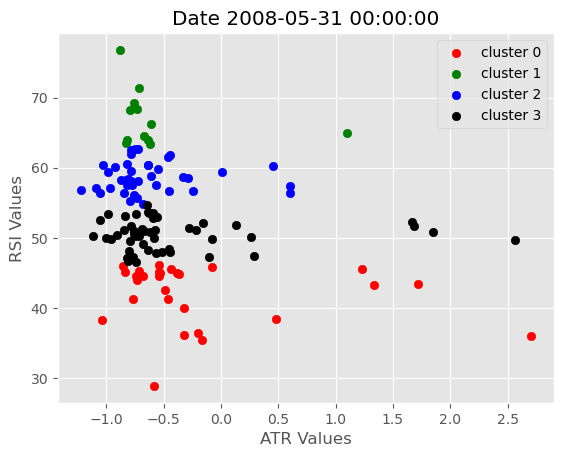

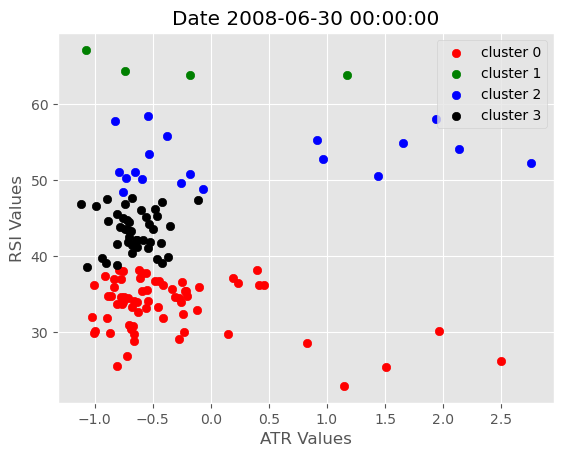

In [47]:
plt.style.use('ggplot')

plot_limit = 5
counter = 0

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plt.xlabel("ATR Values")  # Set x-axis title
    plt.ylabel("RSI Values")  # Set y-axis title
    plot_clusters(g)
    
    counter += 1
    
    if counter == plot_limit:
        break

### For each month select assets based on the cluster
We will form a portfolio based on Efficient Frontier max sharpe ratio optimization
- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis
- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month
- Thus I would like to select stocks corresponding to cluster 3

In [ ]:
filtered_df = data[data['cluster']==3].copy()
 
filtered_df.head()

german_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2008-02-29 AAPL            0.000465  39.534473  1.504577  1.558528  1.612480   
           AIG             0.000469  40.311370  6.279324  6.411866  6.544407   
           ALL             0.000267  46.059007  3.410121  3.454769  3.499417   
           AMGN            0.000930  41.705841  3.467453  3.490204  3.512955   
           BAC             0.000332  42.380018  3.400657  3.447376  3.494096   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2008-02-29 AAPL   -0.713473 -0.323589  -0.076389  -0.196823  -0.118015   
           AIG     4.278882 -2.272614  -0.147535  -0.103466  -0.068202   
           ALL    -0.464730 -0.374989  -0.030272  -0.044049  -0.022612   
           AMGN   -0.989709 -0.244397  -0.022966  -0.009955  -0.062532   
           BAC     1.297582 -0.001472  -0.099887  -0.018592  -0.043903   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2008-02-29 AAPL    -0.016898   0.003463    0.033070  1.131541 -0.175086   
           AIG     -0.054442  -0.046400   -0.028767  1.154089 -0.397838   
           ALL     -0.021386  -0.026206   -0.016820  0.829878  0.045730   
           AMGN    -0.015884  -0.023628   -0.027965  0.968521 -0.307584   
           BAC     -0.035383  -0.023794   -0.017192  1.130287  0.052079   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2008-02-29 AAPL   -0.213477  1.098505 -1.096319        3  
           AIG     1.283310 -0.610155 -1.022664        3  
           ALL    -0.294384 -0.705554  0.652667        3  
           AMGN   -0.581368 -0.092740  0.928136        3  
           BAC     1.538502 -1.394829 -0.834854        3

In [49]:
filtered_df['rsi'].describe()

count    10756.000000
mean        51.890379
std          6.147085
min         29.832393
25%         47.944768
50%         52.217888
75%         55.981560
max         81.062321
Name: rsi, dtype: float64

#### Now we want to create a list of stocks based on at the end of prior month which we would like to use to invest in November
Basically we will be creating a dictionary with the first day the next month, and all of the stocks for the next month in a list

In [50]:
filtered_df = filtered_df.reset_index(level=1)
filtered_df.head()

,ticker,german_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster
date,,,,,,,,,,,,,,,,,,,,
2008-02-29,AAPL,0.000465,39.534473,1.504577,1.558528,1.612480,-0.713473,-0.323589,-0.076389,-0.196823,-0.118015,-0.016898,0.003463,0.033070,1.131541,-0.175086,-0.213477,1.098505,-1.096319,3
2008-02-29,AIG,0.000469,40.311370,6.279324,6.411866,6.544407,4.278882,-2.272614,-0.147535,-0.103466,-0.068202,-0.054442,-0.046400,-0.028767,1.154089,-0.397838,1.283310,-0.610155,-1.022664,3
2008-02-29,ALL,0.000267,46.059007,3.410121,3.454769,3.499417,-0.464730,-0.374989,-0.030272,-0.044049,-0.022612,-0.021386,-0.026206,-0.016820,0.829878,0.045730,-0.294384,-0.705554,0.652667,3
2008-02-29,AMGN,0.000930,41.705841,3.467453,3.490204,3.512955,-0.989709,-0.244397,-0.022966,-0.009955,-0.062532,-0.015884,-0.023628,-0.027965,0.968521,-0.307584,-0.581368,-0.092740,0.928136,3
2008-02-29,BAC,0.000332,42.380018,3.400657,3.447376,3.494096,1.297582,-0.001472,-0.099887,-0.018592,-0.043903,-0.035383,-0.023794,-0.017192,1.130287,0.052079,1.538502,-1.394829,-0.834854,3


In [51]:
# Now we want to move the index and add one day to it
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df.head()

,ticker,german_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster
date,,,,,,,,,,,,,,,,,,,,
2008-03-01,AAPL,0.000465,39.534473,1.504577,1.558528,1.612480,-0.713473,-0.323589,-0.076389,-0.196823,-0.118015,-0.016898,0.003463,0.033070,1.131541,-0.175086,-0.213477,1.098505,-1.096319,3
2008-03-01,AIG,0.000469,40.311370,6.279324,6.411866,6.544407,4.278882,-2.272614,-0.147535,-0.103466,-0.068202,-0.054442,-0.046400,-0.028767,1.154089,-0.397838,1.283310,-0.610155,-1.022664,3
2008-03-01,ALL,0.000267,46.059007,3.410121,3.454769,3.499417,-0.464730,-0.374989,-0.030272,-0.044049,-0.022612,-0.021386,-0.026206,-0.016820,0.829878,0.045730,-0.294384,-0.705554,0.652667,3
2008-03-01,AMGN,0.000930,41.705841,3.467453,3.490204,3.512955,-0.989709,-0.244397,-0.022966,-0.009955,-0.062532,-0.015884,-0.023628,-0.027965,0.968521,-0.307584,-0.581368,-0.092740,0.928136,3
2008-03-01,BAC,0.000332,42.380018,3.400657,3.447376,3.494096,1.297582,-0.001472,-0.099887,-0.018592,-0.043903,-0.035383,-0.023794,-0.017192,1.130287,0.052079,1.538502,-1.394829,-0.834854,3


In [52]:
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
filtered_df.head()

german_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2008-03-01 AAPL            0.000465  39.534473  1.504577  1.558528  1.612480   
           AIG             0.000469  40.311370  6.279324  6.411866  6.544407   
           ALL             0.000267  46.059007  3.410121  3.454769  3.499417   
           AMGN            0.000930  41.705841  3.467453  3.490204  3.512955   
           BAC             0.000332  42.380018  3.400657  3.447376  3.494096   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2008-03-01 AAPL   -0.713473 -0.323589  -0.076389  -0.196823  -0.118015   
           AIG     4.278882 -2.272614  -0.147535  -0.103466  -0.068202   
           ALL    -0.464730 -0.374989  -0.030272  -0.044049  -0.022612   
           AMGN   -0.989709 -0.244397  -0.022966  -0.009955  -0.062532   
           BAC     1.297582 -0.001472  -0.099887  -0.018592  -0.043903   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2008-03-01 AAPL    -0.016898   0.003463    0.033070  1.131541 -0.175086   
           AIG     -0.054442  -0.046400   -0.028767  1.154089 -0.397838   
           ALL     -0.021386  -0.026206   -0.016820  0.829878  0.045730   
           AMGN    -0.015884  -0.023628   -0.027965  0.968521 -0.307584   
           BAC     -0.035383  -0.023794   -0.017192  1.130287  0.052079   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2008-03-01 AAPL   -0.213477  1.098505 -1.096319        3  
           AIG     1.283310 -0.610155 -1.022664        3  
           ALL    -0.294384 -0.705554  0.652667        3  
           AMGN   -0.581368 -0.092740  0.928136        3  
           BAC     1.538502 -1.394829 -0.834854        3

In [53]:
# Now we need to create the date objects
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {} # Make fixed_dates as a dictionary

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level = 0).index.tolist()


first_five_elements = list(fixed_dates.items())[:3]

first_five_elements

[('2008-03-01',
  ['AAPL',
   'AIG',
   'ALL',
   'AMGN',
   'BAC',
   'BAX',
   'BBY',
   'BIIB',
   'BK',
   'BKR',
   'CCL',
   'CMI',
   'COF',
   'COST',
   'CTSH',
   'DD',
   'EA',
   'EXC',
   'FDX',
   'GE',
   'HD',
   'ICE',
   'INTC',
   'ISRG',
   'JNJ',
   'JPM',
   'KLAC',
   'KO',
   'LLY',
   'LMT',
   'LUV',
   'LVS',
   'MAR',
   'MCD',
   'MCK',
   'MET',
   'MMM',
   'MS',
   'NKE',
   'NTAP',
   'ORCL',
   'PEP',
   'PFE',
   'PG',
   'PRU',
   'RTX',
   'SBUX',
   'SCHW',
   'SPGI',
   'STT',
   'T',
   'TRV',
   'TXN',
   'UPS',
   'VLO',
   'VZ',
   'WFC',
   'WYNN']),
 ('2008-04-01',
  ['ADM',
   'AIG',
   'AMAT',
   'AMZN',
   'AXP',
   'BAC',
   'BAX',
   'BBY',
   'BK',
   'BKR',
   'C',
   'CME',
   'CMI',
   'COP',
   'CSCO',
   'CTSH',
   'DD',
   'DE',
   'DIS',
   'F',
   'GS',
   'HON',
   'HPQ',
   'ICE',
   'INTU',
   'LOW',
   'LRCX',
   'MSFT',
   'MU',
   'NVDA',
   'ORCL',
   'RTX',
   'SBUX',
   'SCHW',
   'STT',
   'TGT',
   'TXN',
   'VZ',
  

#### Now we can really use these tickers each month for our portfolios
### Define Portfolio Optimization Function
- We will define function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio
- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function
- Apply single stock weight bounds constraint for diversification (min half of equally weight and max 10% of portfolio)

Efficient Frontier Python pypfopt Documentation: https://pyportfolioopt.readthedocs.io/en/latest/GeneralEfficientFrontier.html

In [54]:
def optimize_weights(prices, lower_bound = 0):
    
    returns = expected_returns.mean_historical_return(prices = prices,
                                                     frequency = 252)
    # 252 days is one year of trading data
    
    cov = risk_models.sample_cov(prices = prices,
                                frequency = 252)
    
    ef = EfficientFrontier(expected_returns = returns,
                          cov_matrix = cov,
                          weight_bounds = (lower_bound, 0.1), 
    # Essentially we want the upper bound of a single stock to be 10% of total portfolio
                          solver = 'SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [55]:
# Check if dates are correct
a = data.index.get_level_values('date').unique()[0]- pd.DateOffset(months = 12)
b = data.index.get_level_values('date').unique()[-1]
print(a, b)

2007-02-28 00:00:00 2026-02-28 00:00:00


In [56]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,
                    start = data.index.get_level_values('date').unique()[0]- pd.DateOffset(months = 12),
                    end = data.index.get_level_values('date').unique()[-1])

new_df.head()

[*********************100%***********************]  209 of 209 completed


Price          Close                                                        \
Ticker          AAPL ABBV ABNB        ABT        ACN       ADBE        ADI   
Date                                                                         
2007-02-28  2.537543  NaN  NaN  17.018833  25.592875  39.250000  23.035673   
2007-03-01  2.611022  NaN  NaN  16.757095  25.185173  39.259998  22.934172   
2007-03-02  2.561535  NaN  NaN  16.517183  25.571421  38.660000  22.426640   
2007-03-05  2.588828  NaN  NaN  16.436167  24.963436  38.520000  22.268040   
2007-03-06  2.644910  NaN  NaN  16.473560  25.206631  39.040001  22.762884   

Price                                        ...    Volume                 \
Ticker            ADM        ADP       ADSK  ...      VTRS        VZ WDAY   
Date                                         ...                            
2007-02-28  21.309124  24.804699  41.150002  ...   2419400  19214681  NaN   
2007-03-01  21.358753  24.809679  40.320000  ...   6762100  15998666  NaN   
2007-03-02  20.936911  24.271208  39.790001  ...  24261200  14027259  NaN   
2007-03-05  20.434423  24.166502  38.830002  ...   6526900  12130407  NaN   
2007-03-06  20.446831  24.331030  39.340000  ...   5755500  15086553  NaN   

Price                                                                    
Ticker          WDC       WFC       WMT     WYNN       XOM XYZ      YUM  
Date                                                                     
2007-02-28  4444089  19013100  63995400  2826900  55723000 NaN  5220979  
2007-03-01  6138985  18585400  61369800  2334600  39472200 NaN  7260742  
2007-03-02  6183173  14720900  55079100  1530600  27454600 NaN  3629119  
2007-03-05  4913622  15652700  42993900  3088500  33039300 NaN  4156030  
2007-03-06  3855222  14467900  44755800  2478500  26626400 NaN  5809651  

[5 rows x 1045 columns]

### Now we have the new rebalanced dates
- We will now calculate the daily returns for each stock which could land in our portfolio
- Then we will loop over each month start, select the stocks for the month and calculate their weights for the next month
- If the maximum sharpe ratio optimization fails for a given month, then we will apply equally-weighted weights.
- Then we will calculate each day's portfolio return

In [57]:
returns_dataframe = np.log(new_df['Close']).diff()
returns_dataframe.head()

Ticker,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,...,VTRS,VZ,WDAY,WDC,WFC,WMT,WYNN,XOM,XYZ,YUM
Date,,,,,,,,,,,,,,,,,,,,,
2007-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-03-01,0.028545,NaN,NaN,-0.015499,-0.016059,0.000255,-0.004416,0.002326,0.000201,-0.020376,...,-0.043937,-0.008054,NaN,-0.004182,-0.001153,-0.008731,-0.010151,-0.009673,NaN,-0.014079
2007-03-02,-0.019135,NaN,NaN,-0.014421,0.015220,-0.015401,-0.022378,-0.019948,-0.021943,-0.013232,...,-0.019437,-0.016853,NaN,-0.029234,-0.006368,-0.001672,-0.035670,-0.013901,NaN,-0.010911
2007-03-05,0.010599,NaN,NaN,-0.004917,-0.024063,-0.003628,-0.007097,-0.024293,-0.004323,-0.024422,...,-0.010625,-0.009641,NaN,-0.021260,-0.011976,-0.007137,-0.046565,-0.000428,NaN,-0.020199
2007-03-06,0.021432,NaN,NaN,0.002272,0.009695,0.013409,0.021979,0.000607,0.006785,0.013049,...,0.011129,0.009641,NaN,0.007684,0.018344,0.011936,0.033558,0.014471,NaN,0.027604


In [58]:
portfolio_df = pd.DataFrame()

limit = 3
counter = 0

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    
    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months = 12)).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days = 1)).strftime('%Y-%m-%d')
    
    print(start_date)
    print(end_date)
    print(cols)
    print(optimization_start_date)
    print(optimization_end_date)
    
    counter += 1
    
    if counter == limit:
        break


2008-03-01
2008-03-31
['AAPL', 'AIG', 'ALL', 'AMGN', 'BAC', 'BAX', 'BBY', 'BIIB', 'BK', 'BKR', 'CCL', 'CMI', 'COF', 'COST', 'CTSH', 'DD', 'EA', 'EXC', 'FDX', 'GE', 'HD', 'ICE', 'INTC', 'ISRG', 'JNJ', 'JPM', 'KLAC', 'KO', 'LLY', 'LMT', 'LUV', 'LVS', 'MAR', 'MCD', 'MCK', 'MET', 'MMM', 'MS', 'NKE', 'NTAP', 'ORCL', 'PEP', 'PFE', 'PG', 'PRU', 'RTX', 'SBUX', 'SCHW', 'SPGI', 'STT', 'T', 'TRV', 'TXN', 'UPS', 'VLO', 'VZ', 'WFC', 'WYNN']
2007-03-01
2008-02-29
2008-04-01
2008-04-30
['ADM', 'AIG', 'AMAT', 'AMZN', 'AXP', 'BAC', 'BAX', 'BBY', 'BK', 'BKR', 'C', 'CME', 'CMI', 'COP', 'CSCO', 'CTSH', 'DD', 'DE', 'DIS', 'F', 'GS', 'HON', 'HPQ', 'ICE', 'INTU', 'LOW', 'LRCX', 'MSFT', 'MU', 'NVDA', 'ORCL', 'RTX', 'SBUX', 'SCHW', 'STT', 'TGT', 'TXN', 'VZ', 'WFC', 'WYNN', 'XOM']
2007-04-01
2008-03-31
2008-05-01
2008-05-31
['ABT', 'ADM', 'AIG', 'BAC', 'BBY', 'BK', 'BMY', 'CCL', 'CI', 'CVS', 'DE', 'HD', 'HPQ', 'HUM', 'INTC', 'KLAC', 'LRCX', 'LVS', 'MAR', 'MDT', 'MET', 'MSFT', 'MSI', 'NKE', 'NVDA', 'ORCL', 'PRU'

In [59]:
print(new_df.columns)

MultiIndex([( 'Close', 'AAPL'),
            ( 'Close', 'ABBV'),
            ( 'Close', 'ABNB'),
            ( 'Close',  'ABT'),
            ( 'Close',  'ACN'),
            ( 'Close', 'ADBE'),
            ( 'Close',  'ADI'),
            ( 'Close',  'ADM'),
            ( 'Close',  'ADP'),
            ( 'Close', 'ADSK'),
            ...
            ('Volume', 'VTRS'),
            ('Volume',   'VZ'),
            ('Volume', 'WDAY'),
            ('Volume',  'WDC'),
            ('Volume',  'WFC'),
            ('Volume',  'WMT'),
            ('Volume', 'WYNN'),
            ('Volume',  'XOM'),
            ('Volume',  'XYZ'),
            ('Volume',  'YUM')],
           names=['Price', 'Ticker'], length=1045)


In [60]:
close_df = new_df['Close']  # This gives all tickers' close prices
optimization_df = close_df[optimization_start_date:optimization_end_date][cols]
optimization_df.head()

Ticker,ABT,ADM,AIG,BAC,BBY,BK,BMY,CCL,CI,CVS,...,NKE,NVDA,ORCL,PRU,TGT,TT,TXN,UPS,WFC,WYNN
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,17.865278,22.704926,855.243713,34.990681,26.482801,27.862791,14.243127,33.477642,46.851067,23.877827,...,10.284679,0.507926,14.863443,48.709576,36.983898,20.589262,21.799702,37.650921,21.598585,58.532639
2007-05-02,17.921686,22.717327,860.006348,35.045643,26.551165,28.193827,14.253055,33.753746,46.437519,24.103394,...,10.379779,0.501967,15.079316,49.517822,36.556000,20.899908,21.968636,38.081585,21.556311,61.328365
2007-05-03,17.990622,22.419558,862.815735,35.196789,26.602444,28.400730,14.570893,33.236061,47.810970,23.957436,...,10.340963,0.511441,15.207236,50.975739,36.326572,21.064367,21.956121,38.162331,21.646910,59.369064
2007-05-04,18.269527,22.369926,865.257996,35.203663,26.323311,28.462801,14.908602,33.097996,48.568630,23.844648,...,10.342900,0.515108,15.215241,51.466831,36.574615,21.201418,21.999928,38.270004,21.695225,58.733135
2007-05-07,18.473219,22.462990,874.417236,35.327320,26.625223,28.552454,14.953300,32.939243,48.716541,23.964073,...,10.455475,0.504871,15.231228,51.794220,36.804035,21.055225,22.024954,38.103115,21.785816,58.349335


Below we are trying to select the tickers that selects the only relevant price history that we want to include. With recency bias, we are able to include tickers that are relevant and long lasting:

- Optimizes our portfolio using only the stocks we will actually hold in the next period
- Uses a rolling window of historical prices (e.g., the past 12 months) for each rebalancing period, which is standard practice in portfolio optimization
- It reduces computation and noise by excluding irrelevant stocks
-  It ensures our optimization is realistic, as it only uses information available up to the decision point

In [61]:
close_df = new_df['Close']  # Select all close prices for all tickers
optimization_df = close_df.loc['2024-08-01':'2025-07-31', fixed_dates['2025-08-01']]
len(optimization_df.columns)

60

In [62]:
optim_col_len = round(1/(len(optimization_df.columns)*2),3)
optim_col_len

0.008

In [63]:
# These will be our weights in August 2025, which we will use to calculate the returns for the next month 
weights = optimize_weights(prices = optimization_df, 
                           lower_bound = optim_col_len)
# Converting the weights element into a DataFrame
weights = pd.DataFrame(weights, index = pd.Series(0))
weights.head()

,AAPL,ABBV,ABNB,ADP,ADSK,AMAT,AMGN,AXP,AZO,BA,...,TSLA,UAL,UBER,UNP,VLO,VRTX,VZ,WFC,WMT,XOM
0,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,...,0.008,0.09027,0.008,0.008,0.008,0.008,0.008,0.008,0.09596,0.008


In [64]:
# Creating a temporary dataframe
temp_df = returns_dataframe['2024-11-01':'2024-11-30']
temp_df.head()

Ticker,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,...,VTRS,VZ,WDAY,WDC,WFC,WMT,WYNN,XOM,XYZ,YUM
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-01,-0.013369,-0.001571,0.012314,0.045100,0.002462,0.009824,0.010567,-0.010378,-0.003672,0.009713,...,0.001723,-0.018446,0.022286,0.008690,-0.003704,0.002924,-0.003547,-0.015795,-0.002353,0.008957
2024-11-04,-0.004046,-0.015247,0.003000,-0.008042,-0.005134,-0.003008,-0.005737,0.012007,0.005813,0.003657,...,-0.014738,-0.007280,0.008412,-0.010069,-0.015268,0.003158,-0.000314,0.031344,0.007457,0.003168
2024-11-05,0.006465,0.006018,0.006917,0.000680,0.004613,0.010478,-0.029835,-0.061529,0.004544,0.014394,...,0.013877,0.004859,0.000456,0.024386,0.005792,0.014808,-0.098011,0.002946,-0.004274,0.014656
2024-11-06,-0.003272,-0.002383,0.022173,-0.007931,0.030332,0.037149,0.038982,0.023942,0.046960,0.035485,...,0.000000,-0.002427,0.042801,0.045057,0.123196,-0.002872,-0.016276,0.017003,0.070153,-0.002602
2024-11-07,0.021147,-0.003435,0.044825,-0.012926,0.012779,-0.007775,0.006696,-0.014563,-0.001082,0.010463,...,0.126834,-0.014438,0.024247,0.007553,-0.037252,0.004902,0.021451,0.001239,-0.031001,0.019822


### Now we want to merge with the weights data frame to get the stock return for each day and the weights for each day

In [65]:
stack_weights = weights.stack().to_frame('weight').reset_index(level=0, drop=True)
stack_weights.head()

,weight
AAPL,0.008
ABBV,0.008
ABNB,0.008
ADP,0.008
ADSK,0.008


In [66]:
# Reassign Temporary DF to
temp_df = temp_df.stack().to_frame('return').reset_index(level = 0)\
        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
              left_index = True,
              right_index = True)\
        .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

temp_df.head()

return  weight
Date       Ticker                  
2024-11-01 AAPL   -0.013369   0.008
           ABBV   -0.001571   0.008
           ABNB    0.012314   0.008
           ADP    -0.003672   0.008
           ADSK    0.009713   0.008

In [67]:
temp_df.index.names = ['date', 'ticker']
temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
temp_df.head()

return  weight  weighted_return
date       ticker                                   
2024-11-01 AAPL   -0.013369   0.008        -0.000107
           ABBV   -0.001571   0.008        -0.000013
           ABNB    0.012314   0.008         0.000099
           ADP    -0.003672   0.008        -0.000029
           ADSK    0.009713   0.008         0.000078

In [68]:
temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
temp_df.head()

,Strategy Return
date,
2024-11-01,0.000980
2024-11-04,-0.002534
2024-11-05,0.013865
2024-11-06,0.032108
2024-11-07,0.000664


In [69]:
portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)
portfolio_df.head()

,Strategy Return
date,
2024-11-01,0.000980
2024-11-04,-0.002534
2024-11-05,0.013865
2024-11-06,0.032108
2024-11-07,0.000664


('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
at least one of the assets must have an expected return exceeding the risk-free rate
at least one of the assets must have an expected return exceeding the risk-free rate
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
at least one of the assets must have an expected return exceeding the risk-free rate
('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
('Please check your objectives/constra

<Axes: xlabel='date'>

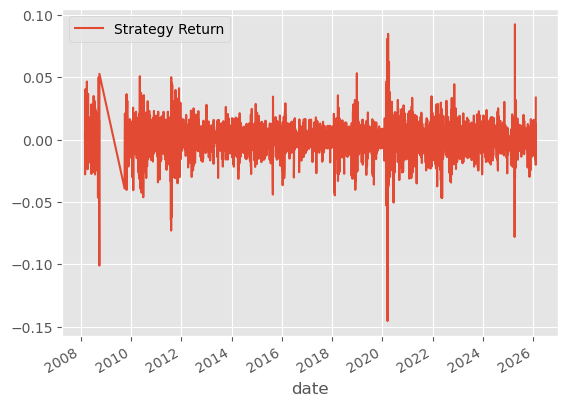

In [70]:
returns_dataframe = np.log(new_df['Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months = 12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days = 1)).strftime('%Y-%m-%d')

        close_df = new_df['Close']
        optimization_df = close_df.loc[optimization_start_date:optimization_end_date, cols]

        weights = optimize_weights(prices = optimization_df,
                                  lower_bound = round(1/(len(optimization_df.columns)*2),3))
        weights = pd.DataFrame(weights, index = pd.Series(0))

        temp_df = returns_dataframe[start_date : end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level = 0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                  left_index = True,
                  right_index = True)\
            .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)
    except Exception as e:
        print(e)

portfolio_df.plot()

In [71]:
# Our equal weights DataFrame if the sharpe optimization fails
pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
             index = optimization_df.columns.tolist(),
             columns = pd.Series(0)).T

,ABBV,AMD,AMT,AVGO,AXP,BLK,CMG,COF,CVS,DHR,...,META,MRNA,MS,NEM,NKE,NVDA,NXPI,TMUS,TSLA,V
0,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,...,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258


In [72]:
returns_dataframe = np.log(new_df['Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        close_df = new_df['Close']
        optimization_df = close_df.loc[optimization_start_date:optimization_end_date, cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                      lower_bound=round(1/(len(optimization_df.columns)*2), 3))
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if not success:
            weights = pd.DataFrame([1/len(optimization_df.columns) for _ in range(len(optimization_df.columns))],
                                   index=optimization_df.columns.tolist(),
                                   columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                   left_index=True,
                   right_index=True)\
            .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    except Exception as e:
        print(e)

portfolio_df.head()

Max Sharpe Optimization failed for 2008-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2008-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2009-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2013-05-01, Continuing with Equal-Weights

,Strategy Return
date,
2008-03-03,-0.001484
2008-03-04,-0.000003
2008-03-05,0.006778
2008-03-06,-0.027870
2008-03-07,-0.008438


<Axes: xlabel='date'>

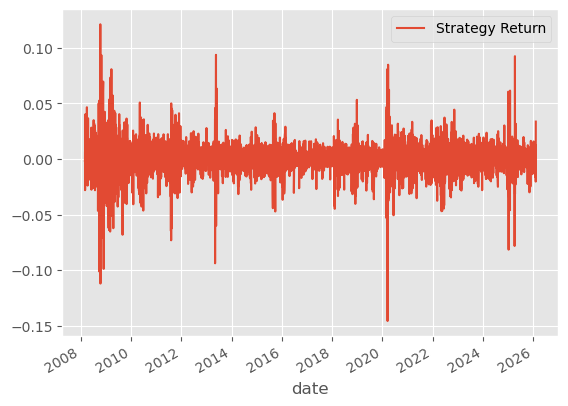

In [73]:
portfolio_df.plot()

## Visualizing Portfolio Returns and Compare to S&P 500 Returns

In [74]:
spy = yf.download(tickers = 'SPY',
                 start = '2005-01-01',
                 end = dt.date.today())
spy.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2005-01-03,81.605972,82.596368,81.334630,82.460694,55748000
2005-01-04,80.608803,81.768787,80.344245,81.714518,69167600
2005-01-05,80.052544,80.893701,80.045759,80.547739,65667300
2005-01-06,80.459557,80.825868,80.222134,80.344238,47814700
2005-01-07,80.344223,80.880123,80.133930,80.703750,55847700


In [75]:
spy_ret = np.log(spy[['Close']]).diff().dropna().rename({'Close': 'SPY Buy & Hold'}, axis = 1)
spy_ret.head()

Price,SPY Buy & Hold
Ticker,SPY
Date,
2005-01-04,-0.012295
2005-01-05,-0.006925
2005-01-06,0.005071
2005-01-07,-0.001434
2005-01-10,0.004718


In [76]:
spy_ret.columns = ['SPY Buy & Hold']

portfolio_df2 = portfolio_df.merge(spy_ret, left_index=True, right_index=True)
portfolio_df2.head()

,Strategy Return,SPY Buy & Hold
2008-03-03,-0.001484,-0.002394
2008-03-04,-0.000003,-0.003828
2008-03-05,0.006778,0.006297
2008-03-06,-0.027870,-0.020915
2008-03-07,-0.008438,-0.010354


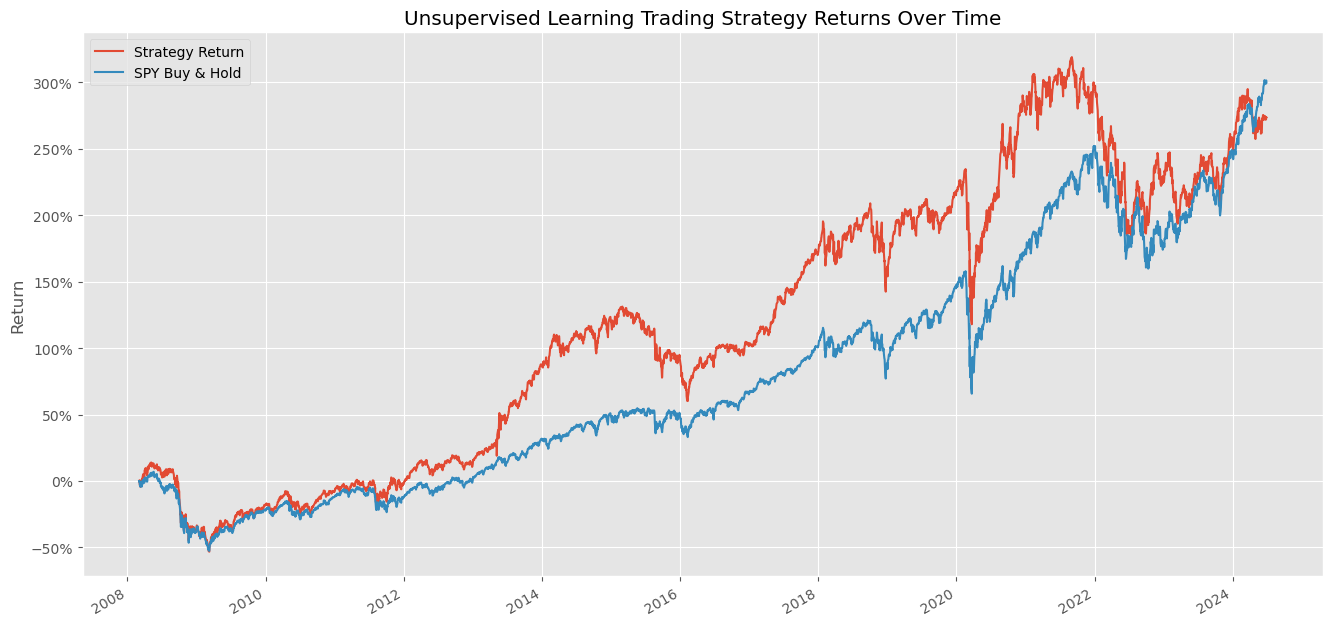

In [77]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df2).cumsum())-1

portfolio_cumulative_return[:'2024-06-28'].plot(figsize=(16,8))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

## Lab Requirement:

Comparison of our unsupervised learning strategy with:
- Moving Average (SMA): Uses 20-day and 50-day moving average crossover
- Exponential Smoothing: Uses EMA with 20-day span
- LSTM: Deep learning model with 60-day lookback

In [78]:
spy_prices = spy[['Close']].copy()
spy_prices.columns = ['price']
spy_returns = spy_ret.copy()
spy_returns.columns = ['return']

#### Moving Average Strategy

In [86]:
def moving_average_strategy(prices, short_window=20, long_window=50):
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices['price']
    signals['short_ma'] = prices['price'].rolling(window=short_window, min_periods=1).mean()
    signals['long_ma'] = prices['price'].rolling(window=long_window, min_periods=1).mean()

    signals['signal'] = 0.0
    signals.loc[signals.index[short_window:], 'signal'] = np.where(
        signals['short_ma'][short_window:] > signals['long_ma'][short_window:], 1.0, 0.0
    )

    signals['positions'] = signals['signal'].diff()
    signals['returns'] = np.log(signals['price'] / signals['price'].shift(1))
    signals['strategy_returns'] = signals['signal'].shift(1) * signals['returns']
    return signals

sma_signals = moving_average_strategy(spy_prices, short_window=20, long_window=50)

### Exponential Smoothing Strategy

In [87]:
def exponential_smoothing_strategy(prices, span=20):
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices['price']
    signals['ema'] = prices['price'].ewm(span=span, adjust=False).mean()
    
    # Generate signals: 1 = buy when price > EMA
    signals['signal'] = np.where(signals['price'] > signals['ema'], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()
    
    # Calculate returns
    signals['returns'] = np.log(signals['price'] / signals['price'].shift(1))
    signals['strategy_returns'] = signals['signal'].shift(1) * signals['returns']
    
    return signals

exp_smooth_signals = exponential_smoothing_strategy(spy_prices, span=20)

### LSTM Strategy

In [110]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def lstm_strategy(prices, seq_length=20, hidden_size=50, retrain_freq=21):
    """
    Improved LSTM strategy with:
    - Monthly retraining (21 trading days)
    - Better model architecture
    - No threshold (more trading activity)
    - Directional prediction
    """
    signals = pd.DataFrame(index=prices.index)
    signals['price'] = prices['price']
    signals['signal'] = 0.0
    
    window_size = 252  # 1 year of training data
    scaler = None
    model = None
    
    for i in range(seq_length + window_size, len(prices)):
        # Retrain monthly (every 21 trading days)
        if (i - seq_length - window_size) % retrain_freq == 0 or model is None:
            # Get training data (only past data!)
            train_prices = prices['price'].iloc[i-window_size-seq_length:i].values
            
            # Scale ONLY on training data
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_train = scaler.fit_transform(train_prices.reshape(-1, 1))
            
            # Create sequences
            X, y = create_sequences(scaled_train, seq_length)
            
            if len(X) < 20:  # Need minimum data
                continue
                
            X_tensor = torch.FloatTensor(X)
            y_tensor = torch.FloatTensor(y)
            
            # Train new model with better architecture
            model = LSTMModel(input_size=1, hidden_size=hidden_size, 
                            num_layers=2, output_size=1, dropout=0.2)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Training with more epochs for monthly retraining
            model.train()
            for epoch in range(50):
                optimizer.zero_grad()
                outputs = model(X_tensor)
                loss = criterion(outputs, y_tensor)
                loss.backward()
                optimizer.step()
        
        # Make prediction for next day
        if model is not None and scaler is not None:
            model.eval()
            with torch.no_grad():
                # Use last seq_length days
                recent_prices = prices['price'].iloc[i-seq_length:i].values
                scaled_recent = scaler.transform(recent_prices.reshape(-1, 1))
                
                test_input = torch.FloatTensor(scaled_recent).unsqueeze(0)
                prediction_scaled = model(test_input).item()
                prediction = scaler.inverse_transform([[prediction_scaled]])[0][0]
                
                current_price = prices['price'].iloc[i]
                
                # Removed threshold - just buy if prediction is higher
                if prediction > current_price:
                    signals.loc[signals.index[i], 'signal'] = 1.0
                else:
                    signals.loc[signals.index[i], 'signal'] = 0.0
    
    signals['positions'] = signals['signal'].diff()
    signals['returns'] = np.log(signals['price'] / signals['price'].shift(1))
    signals['strategy_returns'] = signals['signal'].shift(1) * signals['returns']
    
    return signals

lstm_signals = lstm_strategy(spy_prices, seq_length=20, hidden_size=50, retrain_freq=21)

### Cumulative Returns

In [111]:
# Align all strategies with your unsupervised learning strategy
common_index = portfolio_df2.index.intersection(sma_signals.index)

cumulative_returns = pd.DataFrame(index=common_index)
cumulative_returns['Unsupervised Learning'] = np.exp(np.log1p(portfolio_df2.loc[common_index, 'Strategy Return']).cumsum()) - 1
cumulative_returns['SPY Buy & Hold'] = np.exp(np.log1p(portfolio_df2.loc[common_index, 'SPY Buy & Hold']).cumsum()) - 1
cumulative_returns['SMA Strategy'] = np.exp(sma_signals.loc[common_index, 'strategy_returns'].fillna(0).cumsum()) - 1
cumulative_returns['Exp Smoothing'] = np.exp(exp_smooth_signals.loc[common_index, 'strategy_returns'].fillna(0).cumsum()) - 1
cumulative_returns['LSTM'] = np.exp(lstm_signals.loc[common_index, 'strategy_returns'].fillna(0).cumsum()) - 1

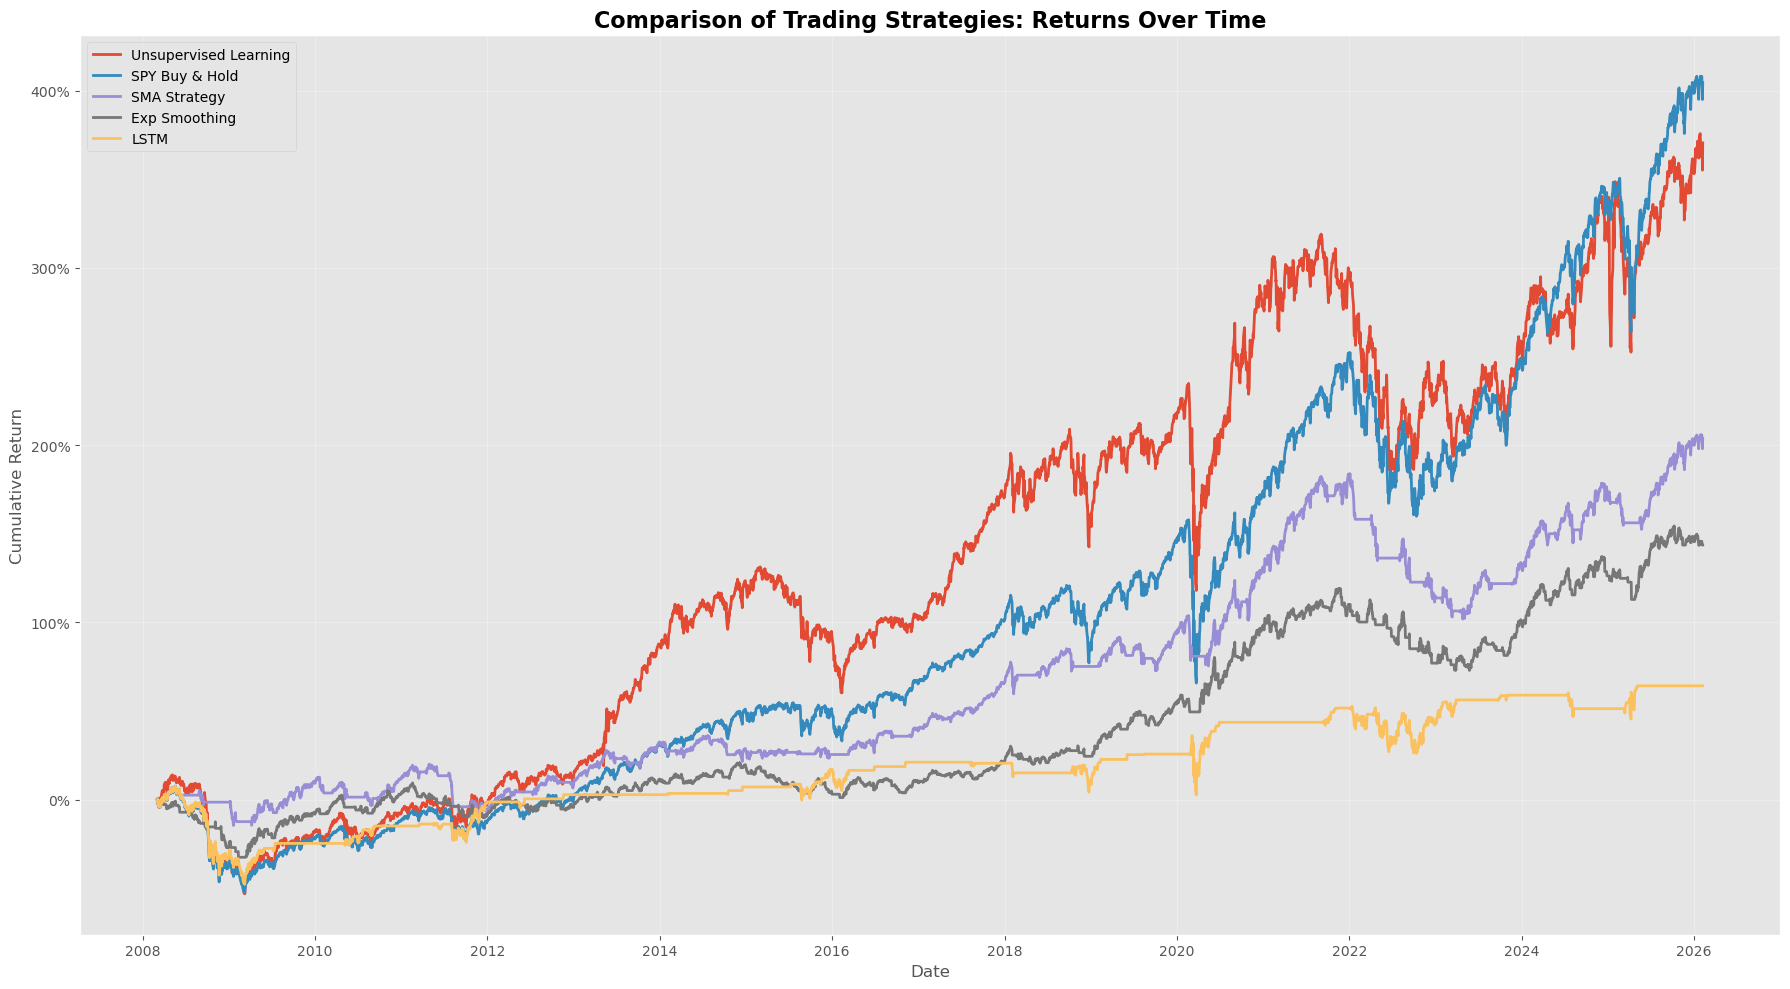

In [113]:
plt.figure(figsize=(18, 10))
plt.style.use('ggplot')

for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col, linewidth=2)

plt.title('Comparison of Trading Strategies: Returns Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [120]:
metrics = pd.DataFrame(index=['Total Return (%)', 
                               'Annualized Return (%)', 
                               'Annualized Volatility (%)', 
                               'Sharpe Ratio',
                               'Max Drawdown (%)',
                               'Win Rate (%)',
                               'Avg Daily Return (bps)',
                               'Best Month (%)',
                               'Worst Month (%)',
                               'Calmar Ratio'])

for col in cumulative_returns.columns:
    # Get returns for this strategy
    if col == 'Unsupervised Learning':
        returns = portfolio_df2.loc[common_index, 'Strategy Return']
    elif col == 'SPY Buy & Hold':
        returns = portfolio_df2.loc[common_index, 'SPY Buy & Hold']
    elif col == 'SMA Strategy':
        returns = sma_signals.loc[common_index, 'strategy_returns']
    elif col == 'Exp Smoothing':
        returns = exp_smooth_signals.loc[common_index, 'strategy_returns']
    else: 
        returns = lstm_signals.loc[common_index, 'strategy_returns']
    
    # Total Return
    total_return = cumulative_returns[col].iloc[-1] * 100
    
    # Annualized Return (compound annual growth rate)
    years = len(returns) / 252
    annualized_return = ((1 + cumulative_returns[col].iloc[-1]) ** (1/years) - 1) * 100
    
    # Annualized Volatility
    annualized_vol = returns.std() * np.sqrt(252) * 100
    
    # Sharpe Ratio (annualized)
    sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() != 0 else 0
    
    # Max Drawdown
    cum_ret = (1 + returns).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    # Win Rate (% of positive return days)
    win_rate = (returns > 0).sum() / len(returns) * 100
    
    # Average Daily Return in basis points
    avg_daily_return = returns.mean() * 10000
    
    # Monthly returns for best/worst
    monthly_returns = returns.resample('M').sum()
    best_month = monthly_returns.max() * 100
    worst_month = monthly_returns.min() * 100
    
    # Calmar Ratio (Annualized Return / Max Drawdown)
    calmar = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    metrics[col] = [
        f"{total_return:.2f}",
        f"{annualized_return:.2f}",
        f"{annualized_vol:.2f}",
        f"{sharpe:.4f}",
        f"{max_drawdown:.2f}",
        f"{win_rate:.2f}",
        f"{avg_daily_return:.2f}",
        f"{best_month:.2f}",
        f"{worst_month:.2f}",
        f"{calmar:.4f}"
    ]


In [118]:
metrics

,Unsupervised Learning,SPY Buy & Hold,SMA Strategy,Exp Smoothing,LSTM
Total Return (%),370.49,404.41,203.66,143.63,64.17
Annualized Return (%),9.03,9.46,6.40,5.10,2.81
Annualized Volatility (%),23.24,19.92,12.21,11.44,16.37
Sharpe Ratio,0.4890,0.5535,0.5078,0.4345,0.1691
Max Drawdown (%),-58.93,-55.66,-29.66,-33.57,-55.66
Win Rate (%),54.38,55.22,38.93,37.60,13.10
Avg Daily Return (bps),4.51,4.38,2.46,1.97,1.10
Best Month (%),15.54,11.95,10.33,9.47,14.79
Worst Month (%),-19.86,-18.05,-14.15,-13.83,-18.05
Calmar Ratio,0.1533,0.1699,0.2157,0.1519,0.0504
